In [1]:
import sys
sys.path.insert(0, '../')
from models.lstm_network import LSTMNet, train_loop, val_loop
from data.data_utils import get_vocabulary, get_unique_labels, get_words_and_labels, split_dataset,\
    word_to_index, word_to_gensim, label_to_index
import torch
import matplotlib.pyplot as plt


In [2]:
# Hyper-parameters for the problem: You'll change these throughout the assignment and see how they affect performance!
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 8 # original 8
SEQ_LEN = 32 # original 32
NUM_EPOCHS = 15
PRE_TRAINED = False
BIDIRECTIONAL = True
SHUFFLE=True
hidden_dim = 64
num_layers = 2
embed_dim = 100

/home/andre/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
dataset = get_words_and_labels(download=False)  # You can set download=False after your first run
print(dataset[0:10])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET')]


### Looking at our data
Once we have a dataset, we want to know more about it so that we can build a good model. The first questions we probably need to ask are: How many unique words and unique labels exist in the dataset? Assuming we want to model every single word, we need a vocabulary/embedding-matrix that's big enough. Similarly, assuming we want to model every class/label, we need an output layer that's big enough!


In [4]:
# Go to data/data_utils.py
# Get the unique word and label lists to know your vocab size
unique_words = get_vocabulary(dataset)
unique_labels = get_unique_labels(dataset)


vocab_size = len(unique_words)
output_size = len(unique_labels)

In [5]:
print(f"Vocabulary size: {vocab_size}")
print(f"Num Classes: {output_size}")

Vocabulary size: 12408
Num Classes: 12


### Creating our network:
By now, you've created a few LSTMs! Inside `models/lstm_network.py`, you'll find a familiar LSTM class that you need to fill out. Define an embedding matrix, a recurrent layer, a linear output layer, and optionally add activation functions or additional linear layers. For 1c) you will return to the LSTM definition and change your forward pass to take in a set of pre-computed embeddings, instead of taking in a set of indices to your own embedding matrix.

In [6]:
# Initialize your LSTM network
pred_model = LSTMNet(
        vocab_size=vocab_size,
        embedding_dim=embed_dim,
        use_embeds=PRE_TRAINED,
        hidden_dim=hidden_dim,
        output_dim=output_size,
        n_layers=num_layers,
        bidirectional=BIDIRECTIONAL,
    ).to(DEVICE)


### Moving from strings to indices:
We can't pass strings into our network, we need to pass indices of the embedding matrix. Inside `data/data_utils.py`, you'll find that you need to complete the `word_to_index` function. This should return a dictionary mapping from word to index, so that you can tokenize new strings. For 1c) you will use the gensim word embeddings instead of the embedding matrix from your network.

In [7]:
# Get a word mapping
if PRE_TRAINED:
    word_to_ind = word_to_gensim()
else:
    word_to_ind = word_to_index(dataset)

### Same thing for labels:

In [8]:
# Get a label mapping
label_to_ind = label_to_index(dataset)

### Splitting the dataset:
We are going to split this dataset 80/20, training and validation data. Complete the `split_dataset` function in` data/data_utils.py` Using the split percentage (0.2 in this case), figure out where you should split the data and create a training/dev split. For 1b) you will come back to this function and shuffle the data before splitting!

In [9]:
# Create your training / dev splits
train_samples, train_labels, test_samples, test_labels = split_dataset(dataset, word_to_ind, label_to_ind,
                                                                           percent_testing=0.2, shuffle=SHUFFLE)


In [10]:
# Create an optimizer and initialize your loss function
### YOUR CODE HERE:
opt = torch.optim.Adam(pred_model.parameters())# Optimizer of your choice
criterion = torch.nn.CrossEntropyLoss()# Loss function of your choice, but cross entropy or negative log likelihood are probably the best bets!
### END YOUR CODE
training_metrics = {'loss': [], 'acc': []}
testing_metrics = {'loss': [], 'acc': []}

### Training and testing:
We're almost ready! Now, you have your dataset, your model, and your optimizer. Fill out the remaining functions in `model/lstm_network.py` to calculate the loss for a sample, update the network, and report loss/accuracy scores. The training loop and validation loops should be pretty familiar by now! Remember _do not train on the validation data!_

In [11]:
# For each epoch, take a training / validation pass over the data. Save training / validation accuracies and losses
for _ in range(NUM_EPOCHS):
    ### YOUR CODE GOES HERE (determine what to pass to train_loop)
    pred_model, loss_total, acc_total = train_loop(model = pred_model, optimizer=opt, loss_fn = criterion,
                                                    samples = train_samples, labels = train_labels,
                                                    batch_size = BATCH_SIZE,
                                                    seq_len=SEQ_LEN, device=DEVICE, pre_trained = PRE_TRAINED)
                                
    ### YOUR CODE ENDS HERE
    training_metrics['loss'].append(loss_total)
    training_metrics['acc'].append(acc_total)
    print(f"Training loss: {loss_total} || Training Accuracy: {acc_total}")
    ### YOUR CODE GOES HERE (determine what to pass to val_loop)
    loss_total, acc_total = val_loop(model = pred_model, loss_fn = criterion,
                                    samples=test_samples, labels = test_labels,
                                    batch_size = BATCH_SIZE,
                                    seq_len=SEQ_LEN, device=DEVICE, pre_trained = PRE_TRAINED)
    ### YOUR CODE ENDS HERE
    testing_metrics['loss'].append(loss_total)
    testing_metrics['acc'].append(acc_total)
    print(f"Validation loss: {loss_total} || Validation Accuracy: {acc_total}")

Training loss: 342.3321684896946 || Training Accuracy: 0.6557159181240063
Validation loss: 49.073767334222794 || Validation Accuracy: 0.8056438791732909
Training loss: 149.97751465439796 || Training Accuracy: 0.8488548290937997
Validation loss: 33.91058346629143 || Validation Accuracy: 0.8676470588235294
Training loss: 96.51220279932022 || Training Accuracy: 0.9046725953895072
Validation loss: 29.654535681009293 || Validation Accuracy: 0.8846879968203497
Training loss: 65.30771975964308 || Training Accuracy: 0.9350655802861685
Validation loss: 28.972215875983238 || Validation Accuracy: 0.890947933227345
Training loss: 43.177341390401125 || Training Accuracy: 0.957695747217806
Validation loss: 29.804402008652687 || Validation Accuracy: 0.8981518282988871
Training loss: 27.712559543550014 || Training Accuracy: 0.9737430445151033
Validation loss: 33.35913388431072 || Validation Accuracy: 0.8980027821939587
Training loss: 18.357319639995694 || Training Accuracy: 0.9825491852146264
Validati

### Reporting:
Now that we've trained a model and gathered some training and testing statistics, let's see how it does! Run the cells below to draw loss and accuracy plots.

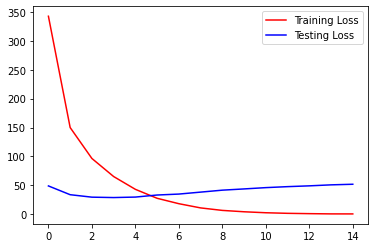

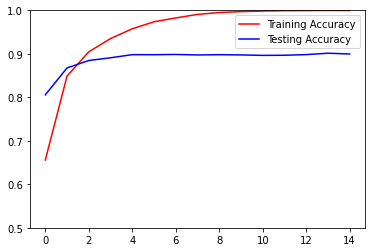

In [12]:
plt.plot(training_metrics['loss'], c='red', label='Training Loss')
plt.plot(testing_metrics['loss'], c='blue', label='Testing Loss')
plt.legend()
plt.show()
plt.plot(training_metrics['acc'], c='red', label='Training Accuracy')
plt.plot(testing_metrics['acc'], c='blue', label='Testing Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.show()
